In [1]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import json

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker-bluy-emo-analysis' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

In [1]:
df = pd.read_csv("https://kabdo-sagemaker-linkage.s3.amazonaws.com/WhiteHouse-WAVES-Released-1210.csv")
df

NameError: name 'pd' is not defined

In [3]:
#randomly select 100 rows and reset the index of the rows so its 0-99
df_rand = df.sample(n=100).reset_index(drop=True)
df_rand

,tweet_id,created_at,tweet,retweets,username
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars
5,856051782027534336,2017-04-23 07:47:04,Missed our big news this week? We've launched ...,0,Sbootcamp
6,851851591141527553,2017-04-11 17:37:00,.@Agricommedia @Agricommedia founder Daliso Ch...,4,BongoHive
7,831121643615330304,2017-02-13 12:43:35,RT @SiliconCape: What's your view on what real...,3,Afrilabs
8,921755711926915077,2017-10-21 15:11:01,Meet one of our #MSFTstartups @mapwizeio who r...,13,bizspark
9,852467280957108224,2017-04-13 10:23:32,RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...,34,ActiveSpaces


In [4]:
#check how many unique tweet ids there are to make sure we haven't selected the same row twice (shouldn't by default)
df_rand.tweet_id.nunique()

100

In [5]:
#rename the tweet column and get rid of the extra space directly behind tweet ('tweet ' -> 'tweet')
df_rand.rename(columns = {'tweet ':'tweet'}, inplace = True)

In [6]:
df_rand['tweet'] = df_rand['tweet'].astype('str')
df_rand.dtypes

tweet_id       int64
created_at    object
tweet         object
retweets       int64
username      object
dtype: object

In [7]:
comprehend = boto3.client(service_name = 'comprehend', region_name= region)

def dom_lang(tweet):
    comprehendout = comprehend.detect_dominant_language(Text = tweet)
    return list((comprehendout.get('Languages')))[0].get('LanguageCode')

df_rand['lang'] = df_rand['tweet'].apply(dom_lang)
df_rand

,tweet_id,created_at,tweet,retweets,username,lang
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB,en
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN,en
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab,en
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars,en
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars,en
5,856051782027534336,2017-04-23 07:47:04,Missed our big news this week? We've launched ...,0,Sbootcamp,en
6,851851591141527553,2017-04-11 17:37:00,.@Agricommedia @Agricommedia founder Daliso Ch...,4,BongoHive,en
7,831121643615330304,2017-02-13 12:43:35,RT @SiliconCape: What's your view on what real...,3,Afrilabs,en
8,921755711926915077,2017-10-21 15:11:01,Meet one of our #MSFTstartups @mapwizeio who r...,13,bizspark,en
9,852467280957108224,2017-04-13 10:23:32,RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...,34,ActiveSpaces,en


In [8]:
# df_rand.set_value('1','lang', 'chi')
# df_rand

In [9]:
#remove all non english tweets
df_rand_en = df_rand[df_rand.lang == 'en']
df_rand_en

,tweet_id,created_at,tweet,retweets,username,lang
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB,en
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN,en
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab,en
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars,en
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars,en
5,856051782027534336,2017-04-23 07:47:04,Missed our big news this week? We've launched ...,0,Sbootcamp,en
6,851851591141527553,2017-04-11 17:37:00,.@Agricommedia @Agricommedia founder Daliso Ch...,4,BongoHive,en
7,831121643615330304,2017-02-13 12:43:35,RT @SiliconCape: What's your view on what real...,3,Afrilabs,en
8,921755711926915077,2017-10-21 15:11:01,Meet one of our #MSFTstartups @mapwizeio who r...,13,bizspark,en
9,852467280957108224,2017-04-13 10:23:32,RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...,34,ActiveSpaces,en


In [10]:
!pip install indicoio

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import indicoio
indicoio.config.api_key = '-'
#if you would like to use this, you will need to sign up with indico.io
#there is a free teir avaiable (10,000 calls with a student account)
#and replace the '-' with 'your key here'

#indicoio.sentiment("I love you very much")
#indicoio.emotion("I did it. I got into Grad School. Not just any program, but a GREAT program. :-)")

In [15]:
def print_tweet(tweet_str):
    return str(tweet_str)

df_rand_en['tweet'].apply(print_tweet)

0     We are carrying out free digital security thre...
1     RT @owenomo: About last night w @DebolaLagos, ...
2     The #MBSAInnovationChallenge is awaiting your ...
3     Who's ready to see some startups?! First up: @...
4     Are you enjoying #sswkuwait? Share your though...
5     Missed our big news this week? We've launched ...
6     .@Agricommedia @Agricommedia founder Daliso Ch...
7     RT @SiliconCape: What's your view on what real...
8     Meet one of our #MSFTstartups @mapwizeio who r...
9     RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...
10    RT @navialifecare: Looking forward to pitching...
11    shoutout to our partners for #SSWHK that enabl...
12    Leverage #Azure quickstart templates to get mo...
13    @LetsTalkPaymnts @bbvaopentalent @bbva @BBVARe...
14    RT @simunza: Only 3% of Zambians are insured. ...
15    .@TonyOElumelu: For Africa to see a rise in jo...
16    Exciting conversations on #entrepreneurship, #...
17    .@UNIONBANK_NG @bosuntijani The #UBNCenten

In [16]:
def tweet_to_emo(tweet):
    emotions = indicoio.emotion(tweet)
    print(json.dumps(emotions, indent = 4))
    return(max(emotions, key=emotions.get))

df_rand_en['emotion'] = df_rand_en['tweet'].apply(tweet_to_emo)

{
    "fear": 0.7868530750274658,
    "sadness": 0.12901106476783752,
    "anger": 0.05672469735145569,
    "joy": 0.02597389556467533,
    "surprise": 0.0014372970908880234
}
{
    "joy": 0.35237550735473633,
    "surprise": 0.3096134662628174,
    "sadness": 0.2253199815750122,
    "fear": 0.07368291169404984,
    "anger": 0.03900810703635216
}
{
    "fear": 0.6829433441162109,
    "sadness": 0.17115506529808044,
    "anger": 0.0887100100517273,
    "joy": 0.05089446157217026,
    "surprise": 0.0062971157021820545
}
{
    "fear": 0.3485998213291168,
    "surprise": 0.2635616660118103,
    "joy": 0.24046775698661804,
    "sadness": 0.10744689404964447,
    "anger": 0.03992386907339096
}
{
    "sadness": 0.45803302526474,
    "fear": 0.31954512000083923,
    "anger": 0.12762117385864258,
    "joy": 0.08317424356937408,
    "surprise": 0.011626437306404114
}
{
    "fear": 0.47742679715156555,
    "sadness": 0.38869163393974304,
    "joy": 0.0819997489452362,
    "anger": 0.0498337969183

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
df_rand_en

,tweet_id,created_at,tweet,retweets,username,lang,emotion
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB,en,fear
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN,en,joy
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab,en,fear
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars,en,fear
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars,en,sadness
5,856051782027534336,2017-04-23 07:47:04,Missed our big news this week? We've launched ...,0,Sbootcamp,en,fear
6,851851591141527553,2017-04-11 17:37:00,.@Agricommedia @Agricommedia founder Daliso Ch...,4,BongoHive,en,sadness
7,831121643615330304,2017-02-13 12:43:35,RT @SiliconCape: What's your view on what real...,3,Afrilabs,en,sadness
8,921755711926915077,2017-10-21 15:11:01,Meet one of our #MSFTstartups @mapwizeio who r...,13,bizspark,en,fear
9,852467280957108224,2017-04-13 10:23:32,RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...,34,ActiveSpaces,en,sadness


In [18]:
df_rand_en.loc[:,'fear'] = (df_rand_en['emotion'] == 'fear').astype(int) 
df_rand_en.loc[:,'sadness'] = (df_rand_en['emotion'] == 'sadness').astype(int) 
df_rand_en.loc[:,'joy'] = (df_rand_en['emotion'] == 'joy').astype(int) 
df_rand_en.loc[:,'anger'] = (df_rand_en['emotion'] == 'anger').astype(int) 
df_rand_en.loc[:,'surprise'] = (df_rand_en['emotion'] == 'surprise').astype(int) 
df_rand_en

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,tweet_id,created_at,tweet,retweets,username,lang,emotion,fear,sadness,joy,anger,surprise
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB,en,fear,1,0,0,0,0
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN,en,joy,0,0,1,0,0
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab,en,fear,1,0,0,0,0
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars,en,fear,1,0,0,0,0
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars,en,sadness,0,1,0,0,0
5,856051782027534336,2017-04-23 07:47:04,Missed our big news this week? We've launched ...,0,Sbootcamp,en,fear,1,0,0,0,0
6,851851591141527553,2017-04-11 17:37:00,.@Agricommedia @Agricommedia founder Daliso Ch...,4,BongoHive,en,sadness,0,1,0,0,0
7,831121643615330304,2017-02-13 12:43:35,RT @SiliconCape: What's your view on what real...,3,Afrilabs,en,sadness,0,1,0,0,0
8,921755711926915077,2017-10-21 15:11:01,Meet one of our #MSFTstartups @mapwizeio who r...,13,bizspark,en,fear,1,0,0,0,0
9,852467280957108224,2017-04-13 10:23:32,RT @iafrikan: 🌍 Rebecca Enonchong (@africatech...,34,ActiveSpaces,en,sadness,0,1,0,0,0


In [19]:
test = df_rand_en
test.head()

,tweet_id,created_at,tweet,retweets,username,lang,emotion,fear,sadness,joy,anger,surprise
0,836885037089976321,2017-03-01 10:25:16,We are carrying out free digital security thre...,4,Cc_HUB,en,fear,1,0,0,0,0
1,927277300697112576,2017-11-05 20:51:51,"RT @owenomo: About last night w @DebolaLagos, ...",10,TonyElumeluFDN,en,joy,0,0,1,0,0
2,909408863010607105,2017-09-17 13:29:03,The #MBSAInnovationChallenge is awaiting your ...,1,TheLaunchLab,en,fear,1,0,0,0,0
3,867617982243098624,2017-05-25 05:47:01,Who's ready to see some startups?! First up: @...,2,Seedstars,en,fear,1,0,0,0,0
4,925752852085174272,2017-11-01 15:54:14,Are you enjoying #sswkuwait? Share your though...,2,Seedstars,en,sadness,0,1,0,0,0


In [20]:
sum_df = test.groupby('username').agg('sum')
sum_df.head()

,tweet_id,retweets,fear,sadness,joy,anger,surprise
username,,,,,,,
ActiveSpaces,3.576394e+18,36.0,1.0,1.0,1.0,0.0,1.0
Afrilabs,5.313138e+18,112.0,1.0,3.0,1.0,1.0,0.0
BongoHive,5.307833e+18,16.0,2.0,3.0,0.0,0.0,1.0
C4DLab,3.637426e+18,26.0,0.0,2.0,2.0,0.0,0.0
Cc_HUB,1.048628e+19,106.0,5.0,5.0,2.0,0.0,0.0


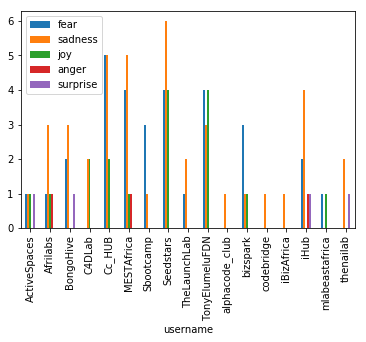

In [22]:
import matplotlib.pyplot as plt
sum_df.plot(y= ['fear', 'sadness', 'joy', 'anger', 'surprise'], kind = 'bar')

In [23]:
sum_df.drop('tweet_id', axis = 1, inplace = True)
sum_df.drop('retweets', axis = 1, inplace = True)
sum_df

,fear,sadness,joy,anger,surprise
username,,,,,
ActiveSpaces,1.0,1.0,1.0,0.0,1.0
Afrilabs,1.0,3.0,1.0,1.0,0.0
BongoHive,2.0,3.0,0.0,0.0,1.0
C4DLab,0.0,2.0,2.0,0.0,0.0
Cc_HUB,5.0,5.0,2.0,0.0,0.0
MESTAfrica,4.0,5.0,1.0,1.0,0.0
Sbootcamp,3.0,1.0,0.0,0.0,0.0
Seedstars,4.0,6.0,4.0,0.0,0.0
TheLaunchLab,1.0,2.0,0.0,0.0,0.0


In [38]:
from sklearn.cluster import KMeans

train_data = sum_df.values.astype('float32')

Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train_data)
    Sum_of_squared_distances.append(km.inertia_)

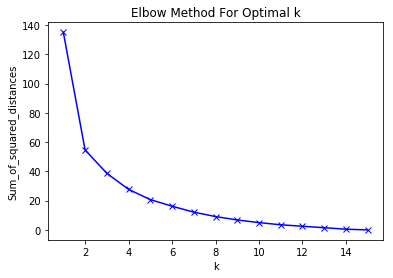

In [39]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
from sagemaker import KMeans

num_clusters = 4
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/kmeans/',              
                k=num_clusters)

In [41]:
%%time
kmeans.fit(kmeans.record_set(train_data))

2019-07-16 19:27:54 Starting - Starting the training job...
2019-07-16 19:27:56 Starting - Launching requested ML instances......
2019-07-16 19:29:01 Starting - Preparing the instances for training.........
2019-07-16 19:30:46 Downloading - Downloading input data
2019-07-16 19:30:46 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[07/16/2019 19:31:07 INFO 140572939913024] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'

In [ ]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')
#KMeans endpoint

--------------------------------------------------------------------------------------------------!CPU times: user 605 ms, sys: 3.23 ms, total: 609 ms
Wall time: 8min 15s


In [ ]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 260 ms


In [ ]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

0.0    7
2.0    6
3.0    2
1.0    2
Name: 0, dtype: int64

In [ ]:
sum_df['labels']=list(map(int, cluster_labels))
sum_df

,fear,sadness,joy,anger,surprise,labels
username,,,,,,
ActiveSpaces,1.0,1.0,1.0,0.0,1.0,0
Afrilabs,1.0,3.0,1.0,1.0,0.0,2
BongoHive,2.0,3.0,0.0,0.0,1.0,2
C4DLab,0.0,2.0,2.0,0.0,0.0,0
Cc_HUB,5.0,5.0,2.0,0.0,0.0,1
MESTAfrica,4.0,5.0,1.0,1.0,0.0,1
Sbootcamp,3.0,1.0,0.0,0.0,0.0,2
Seedstars,4.0,6.0,4.0,0.0,0.0,3
TheLaunchLab,1.0,2.0,0.0,0.0,0.0,2
